# Supervised Sector Classification

Let's now use the features we constructed and the known sectors to build a supervised classification model. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
agreements_features = pd.read_pickle("classification_features.pkl")

For now, let's just build a model only on the completely labeled data.

In [7]:
labeled_set = agreements_features.dropna(how='any',inplace=False,subset=['project_description_lsi','Project Name','project_name_lsi','sector_id'])
labeled_set = labeled_set.loc[labeled_set.project_name_lsi.apply(len) != 0]
labeled_set = labeled_set.loc[labeled_set.project_description_lsi.apply(len) != 0]

In [8]:
labeled_set.major_sector_name.value_counts()

Public Admin                   178
Transportation                 118
Water/Sanitation/Waste         116
Agriculture                    104
Energy and Extractives          79
Industry and Trade/Services     70
Education                       69
Health                          63
Social Protection               56
Financial Sector                47
Info and Communication           7
Name: major_sector_name, dtype: int64

"Info and Communication" only has 7 data points. We'll just drop it and train on the other 10 classes.

In [9]:
labeled_set = labeled_set.loc[labeled_set.major_sector_name != "Info and Communication"]
labeled_set.major_sector_name.value_counts()

Public Admin                   178
Transportation                 118
Water/Sanitation/Waste         116
Agriculture                    104
Energy and Extractives          79
Industry and Trade/Services     70
Education                       69
Health                          63
Social Protection               56
Financial Sector                47
Name: major_sector_name, dtype: int64

For features, we will use the year, the top 20 topic weights from the LSI topic model for both the project name and the project description, and also the computed similarities to the sector description. Oh, and the year.

In [10]:
desc_features = np.stack(labeled_set.project_description_lsi.to_numpy())[:,:20]
name_features = np.stack(labeled_set.project_name_lsi.to_numpy())[:,:20]
desc_distances = np.stack(labeled_set.description_similarities_lsi.to_numpy()).squeeze()
name_distances = np.stack(labeled_set.project_name_similarities_lsi.to_numpy()).squeeze()
X_features = np.concatenate([desc_features,name_features,desc_distances,name_distances],axis=1) #labeled_set.year.to_numpy().reshape((-1,1)),
#X_features = np.concatenate([desc_features,name_features],axis=1)
y = labeled_set['sector_id'].apply(int).to_numpy().ravel()

In [12]:
#Get sector names
with open("../world_bank_sectors.txt") as f:
  sectors = f.read()

sectors_list = sectors.split("\n")

sector_dict = dict()
current_major_sector = ''
for sector in sectors_list:
    if sector == '':
        current_major_sector = ''
        continue
    if current_major_sector == '':
        current_major_sector = sector
        sector_dict[current_major_sector] = []
        continue
    if current_major_sector in sector_dict.keys():
        sector_dict[current_major_sector].append(sector)
sectors = list(sector_dict.keys())
sectors.pop(6) #remove the ignored sector

'Info and Communication'

In [13]:
sectors

['Agriculture',
 'Education',
 'Energy and Extractives',
 'Financial Sector',
 'Health',
 'Industry and Trade/Services',
 'Public Admin',
 'Social Protection',
 'Transportation',
 'Water/Sanitation/Waste']

We'll set aside 25% of the data as a test set.

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features,y,train_size=0.75,stratify=y,random_state=52323)

Let's build some models.

In [15]:
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


Start with a random forest. Those typically work pretty well. We'll run a grid search over hyperparameters and choose the parameters with the best cross-validation accuracy.

In [43]:
rf_pred = ensemble.RandomForestClassifier(n_estimators=200,max_depth=7,class_weight="balanced",random_state=4252)
rf_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [6, 7, 8, None],
    #"criterion": ['gini','entropy'],
    "ccp_alpha": [0, 0.001, 0.002, 0.005]
}
rf = GridSearchCV(estimator=rf_pred,param_grid=rf_grid,scoring=make_scorer(accuracy_score),n_jobs=4)

In [44]:
rf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=7, n_estimators=200,
                                              random_state=4252),
             n_jobs=4,
             param_grid={'ccp_alpha': [0, 0.001, 0.002, 0.005],
                         'max_depth': [6, 7, 8, None],
                         'n_estimators': [200, 300, 400]},
             scoring=make_scorer(accuracy_score))

In [45]:
y_train_pred = rf.predict(X_train)
rf_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = rf.predict(X_test)
rf_test_acc = accuracy_score(y_test,y_test_pred)
rf_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
rf_top2_test_acc = top_k_accuracy_score(y_test,rf.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(rf_train_acc,3))
print("Test Accuracy:", np.round(rf_test_acc,3))
print("Top 2 Test Accuracy:", np.round(rf_top2_test_acc,3))

Train Accuracy: 0.985
Test Accuracy: 0.667
Top 2 Test Accuracy: 0.782


In [46]:
rf.best_params_

{'ccp_alpha': 0.002, 'max_depth': None, 'n_estimators': 200}

<Figure size 720x720 with 0 Axes>

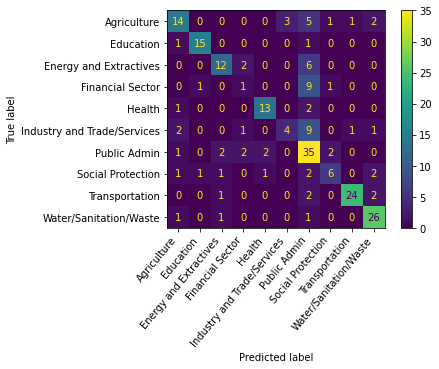

In [47]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

<Figure size 720x720 with 0 Axes>

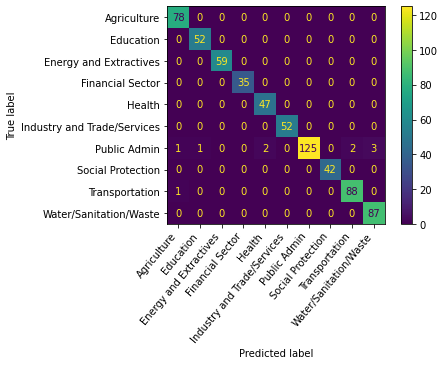

In [48]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf,X_train,y_train,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

Now replace the model with the best version.

In [49]:
rf = rf.best_estimator_

In [50]:
rf.feature_importances_.argsort()

array([ 2, 57,  0, 20, 34, 32, 36, 45, 23, 46, 60, 56, 47, 35, 22, 15, 14,
       21,  3, 58, 16,  1, 38, 49, 17, 30, 39, 31, 27, 61, 33, 18, 43, 25,
       54, 26, 28, 53, 19, 24, 59, 37, 12, 11, 55, 48,  7, 29, 51, 10, 52,
       13, 50,  4, 41, 44,  6, 40,  8,  9,  5, 42])

In [69]:
lin = LogisticRegression(class_weight="balanced",C=1,penalty="elasticnet",l1_ratio=0.8,solver='saga',max_iter=5000, random_state=424)
logistic_grid = {
    "C": [0.1, 0.2, 0.5, 0.75, 1],
    "l1_ratio": [0.0, 0.2, 0.5, 0.8, 1.0]
}
logistic_pipe = Pipeline([
    ('scale',StandardScaler()),
    ('logistic',GridSearchCV(estimator=lin,param_grid=logistic_grid,scoring=make_scorer(accuracy_score),n_jobs=4))
])
logistic_pipe.fit(X_train,y_train)

/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('scale', StandardScaler()),
                ('logistic',
                 GridSearchCV(estimator=LogisticRegression(C=1,
                                                           class_weight='balanced',
                                                           l1_ratio=0.8,
                                                           max_iter=5000,
                                                           penalty='elasticnet',
                                                           random_state=424,
                                                           solver='saga'),
                              n_jobs=4,
                              param_grid={'C': [0.1, 0.2, 0.5, 0.75, 1],
                                          'l1_ratio': [0.0, 0.2, 0.5, 0.8,
                                                       1.0]},
                              scoring=make_scorer(accuracy_score)))])

In [70]:
logistic_pipe['logistic'].best_params_

{'C': 0.1, 'l1_ratio': 0.0}

In [71]:
y_train_pred = logistic_pipe.predict(X_train)
log_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = logistic_pipe.predict(X_test)
log_test_acc = accuracy_score(y_test,y_test_pred)
log_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
log_top2_test_acc = top_k_accuracy_score(y_test,logistic_pipe.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(log_train_acc,3))
print("Test Accuracy:", np.round(log_test_acc,3))
print("Top 2 Test Accuracy:", np.round(log_top2_test_acc,3))

Train Accuracy: 0.705
Test Accuracy: 0.649
Top 2 Test Accuracy: 0.751


<Figure size 720x720 with 0 Axes>

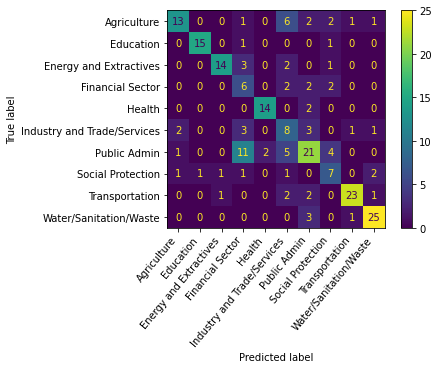

In [72]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(logistic_pipe,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

In [73]:
logistic_est = logistic_pipe['logistic'].best_estimator_
logistic_pipe.steps.pop(1)
logistic_pipe.steps.append(('logistic',logistic_est))

In [74]:
svm = SVC(max_iter=5000,probability=True,class_weight="balanced",C=2,random_state=1212)
svm_grid = {
    "C": [0.5, 1, 2, 5],
    "kernel": ['linear','rbf']
}
pipe = Pipeline([('scale',StandardScaler()),('svm',GridSearchCV(estimator=svm,param_grid=svm_grid,scoring=make_scorer(accuracy_score),n_jobs=4))])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('svm',
                 GridSearchCV(estimator=SVC(C=2, class_weight='balanced',
                                            max_iter=5000, probability=True,
                                            random_state=1212),
                              n_jobs=4,
                              param_grid={'C': [0.5, 1, 2, 5],
                                          'kernel': ['linear', 'rbf']},
                              scoring=make_scorer(accuracy_score)))])

In [75]:
y_train_pred = pipe.predict(X_train)
svm_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = pipe.predict(X_test)
svm_test_acc = accuracy_score(y_test,y_test_pred)
svm_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
svm_top2_test_acc = top_k_accuracy_score(y_test,pipe.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(svm_train_acc,3))
print("Test Accuracy:", np.round(svm_test_acc,3))
print("Top 2 Test Accuracy:", np.round(svm_top2_test_acc,3))

Train Accuracy: 0.815
Test Accuracy: 0.658
Top 2 Test Accuracy: 0.813


In [77]:
pipe['svm'].best_params_

{'C': 2, 'kernel': 'rbf'}

<Figure size 720x720 with 0 Axes>

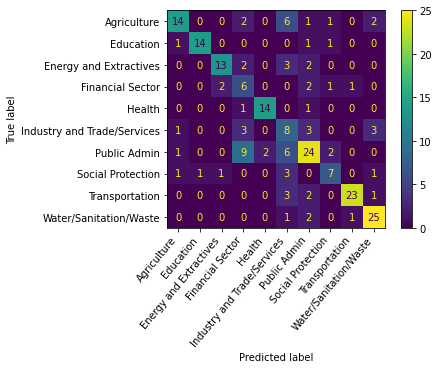

In [78]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(pipe,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

<Figure size 720x720 with 0 Axes>

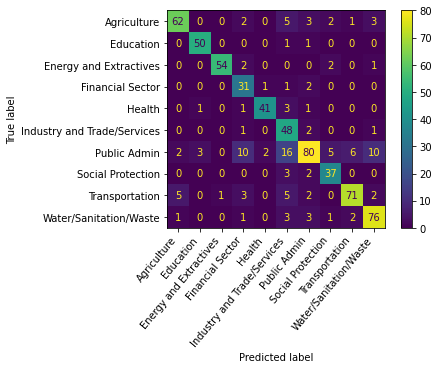

In [79]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(pipe,X_train,y_train,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

In [80]:
svm_est = pipe['svm'].best_estimator_
pipe.steps.pop(1)
pipe.steps.append(('svm',svm_est))

In [81]:
mlp_est = MLPClassifier(hidden_layer_sizes=(32,16),max_iter=200,random_state=52234)
mlp_grid = {
    "hidden_layer_sizes": [(32, 16), (32, 32), (16, 16), (48, 48)],
    "max_iter": [200, 300, 400]
}
mlp = Pipeline([('scale', StandardScaler()),('mlp',GridSearchCV(estimator=mlp_est,param_grid=mlp_grid,scoring=make_scorer(accuracy_score),n_jobs=4))])
mlp.fit(X_train,y_train)

/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scale', StandardScaler()),
                ('mlp',
                 GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(32,
                                                                          16),
                                                      random_state=52234),
                              n_jobs=4,
                              param_grid={'hidden_layer_sizes': [(32, 16),
                                                                 (32, 32),
                                                                 (16, 16),
                                                                 (48, 48)],
                                          'max_iter': [200, 300, 400]},
                              scoring=make_scorer(accuracy_score)))])

In [82]:
y_train_pred = mlp.predict(X_train)
mlp_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = mlp.predict(X_test)
mlp_test_acc = accuracy_score(y_test,y_test_pred)
mlp_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
mlp_top2_test_acc = top_k_accuracy_score(y_test,mlp.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(mlp_train_acc,3))
print("Test Accuracy:", np.round(mlp_test_acc,3))
print("Top 2 Test Accuracy:", np.round(mlp_top2_test_acc,3))

Train Accuracy: 0.933
Test Accuracy: 0.671
Top 2 Test Accuracy: 0.764


In [83]:
mlp['mlp'].best_params_

{'hidden_layer_sizes': (32, 16), 'max_iter': 200}

In [84]:
mlp_est = mlp['mlp'].best_estimator_
mlp.steps.pop(1)
mlp.steps.append(('mlp',mlp_est))

In [95]:
ens = VotingClassifier([
    ('rf',rf),
    ('logistic',logistic_pipe),
    ('svm',pipe),
    ('mlp',mlp)
],voting='soft',weights=[0.3,0.2,0.2,0.3])
ens.fit(X_train,y_train)

/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(ccp_alpha=0.002,
                                                     class_weight='balanced',
                                                     n_estimators=200,
                                                     random_state=4252)),
                             ('logistic',
                              Pipeline(steps=[('scale', StandardScaler()),
                                              ('logistic',
                                               LogisticRegression(C=0.1,
                                                                  class_weight='balanced',
                                                                  l1_ratio=0.0,
                                                                  max_iter=5000,
                                                                  penalty='elasticnet',
                                                                  random_state=424

In [96]:
y_train_pred = ens.predict(X_train)
ens_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = ens.predict(X_test)
ens_test_acc = accuracy_score(y_test,y_test_pred)
ens_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
ens_top2_test_acc = top_k_accuracy_score(y_test,ens.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(ens_train_acc,3))
print("Test Accuracy:", np.round(ens_test_acc,3))
print("Top 2 Test Accuracy:", np.round(ens_top2_test_acc,3))

Train Accuracy: 0.947
Test Accuracy: 0.711
Top 2 Test Accuracy: 0.818


In [97]:
top_k_accuracy_score(y_test,ens.predict_proba(X_test),k=5)

0.9377777777777778

<Figure size 720x720 with 0 Axes>

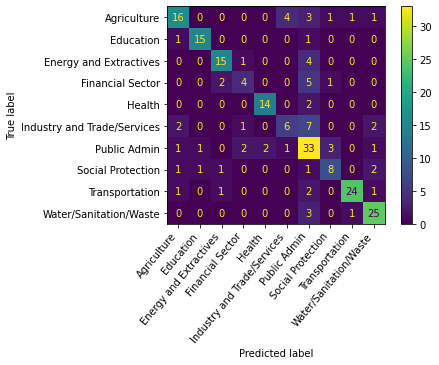

In [98]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(ens,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

Let's use the ensemble model, as it's better than any of the individual models. To make predictions for the unlabeled data, we'll first fit it on the whole dataset.

In [99]:
ens.fit(X_features,y)

/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(ccp_alpha=0.002,
                                                     class_weight='balanced',
                                                     n_estimators=200,
                                                     random_state=4252)),
                             ('logistic',
                              Pipeline(steps=[('scale', StandardScaler()),
                                              ('logistic',
                                               LogisticRegression(C=0.1,
                                                                  class_weight='balanced',
                                                                  l1_ratio=0.0,
                                                                  max_iter=5000,
                                                                  penalty='elasticnet',
                                                                  random_state=424

In [100]:
y_pred = ens.predict(X_features)
accuracy_score(y,y_pred)

0.9266666666666666

<Figure size 720x720 with 0 Axes>

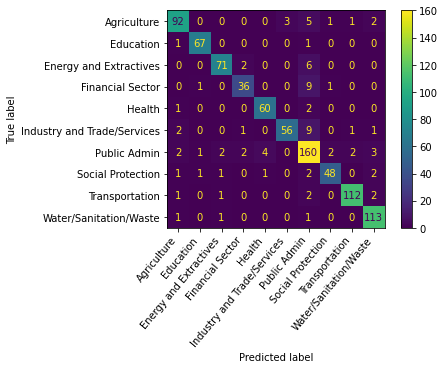

In [101]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf,X_features,y,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

In [102]:
top_k_accuracy_score(y,rf.predict_proba(X_features),k=2)

0.9455555555555556

In [131]:
good_features = agreements_features.dropna(how='any',inplace=False,subset=['project_desc','Project Name'])
good_features = good_features.loc[good_features.project_name_lsi.apply(len) != 0]

In [132]:
desc_features = np.stack(good_features.project_description_lsi.to_numpy())[:,:20]
name_features = np.stack(good_features.project_name_lsi.to_numpy())[:,:20]
desc_distances = np.stack(good_features.description_similarities_lsi.to_numpy()).squeeze()
name_distances = np.stack(good_features.project_name_similarities_lsi.to_numpy()).squeeze()
X_in = np.concatenate([desc_features,name_features,desc_distances,name_distances],axis=1)

good_features['supervised_predictions'] = ens.predict(X_in)

In [133]:
good_features.supervised_predictions.value_counts()

7     629
9     400
10    328
2     321
0     271
5     247
1     182
8     162
3     149
4     148
Name: supervised_predictions, dtype: int64

In [134]:
good_features['predicted_sector'] = good_features.supervised_predictions.apply(lambda x: sectors[x] if x < 6 else sectors[x-1])

In [135]:
len(good_features)

2837

In [136]:
sector_counts = good_features.predicted_sector.value_counts()

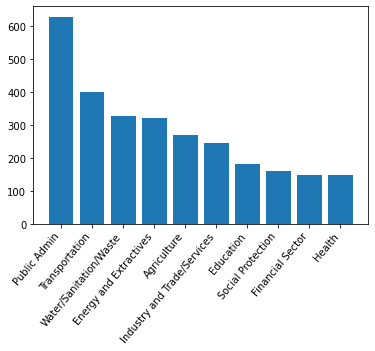

In [137]:
plt.plot(figsize=(8,8))
plt.bar(sector_counts.index, sector_counts.values)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

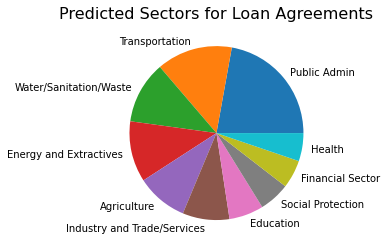

In [138]:
plt.plot(figsize=(12,12))
plt.pie(sector_counts.values,labels=sector_counts.index)
plt.title("Predicted Sectors for Loan Agreements",fontsize=16)
plt.show()

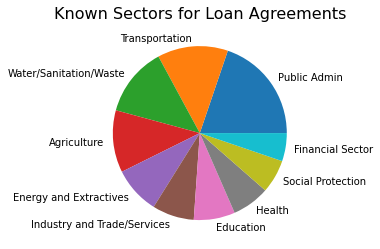

In [139]:
validated_sector_counts = labeled_set.major_sector_name.value_counts()
plt.plot(figsize=(12,12))
plt.pie(validated_sector_counts.values,labels=validated_sector_counts.index)
plt.title("Known Sectors for Loan Agreements",fontsize=16)
plt.show()

The distribution is roughly the same for the top 3 categories, and isn't too wildly off for the others. These seem like reasonable predictions.

Let's do some spot checks.

In [146]:
for x in good_features.sample().iterrows():
    print(x[1])

id                                                              869741468034839250
Project Name                                    Second Madras Water Supply Project
project_desc                     SCHEDULE 2\n\nDescription of the Project\n\nTh...
project_name_lsi                 [0.021353647076421553, -0.026940981733325396, ...
project_description_lsi          [0.5712712509767667, -0.11687338149597061, -0....
project_name_similarities_lsi    [[-0.0014119066, 0.0050165933, 0.018931, 0.006...
description_similarities_lsi     [[0.103404105, 0.019341305, 0.037000716, 0.006...
sector_id                                                                      NaN
major_sector_name                                                              NaN
supervised_predictions                                                          10
predicted_sector                                            Water/Sanitation/Waste
Name: 827, dtype: object


In [152]:
for idx, agreement in good_features.sample(10).iterrows():
    print(agreement['Project Name'], 'was classified as belonging to sector', agreement.predicted_sector)
    #print("Project Description:", agreement.project_desc[500:1000])
    print("Actual sector:", agreement.major_sector_name)
    print("\n\n")

Agricultural Sector Investment Loan was classified as belonging to sector Agriculture
Actual sector: Agriculture



Banking Reform Assistance Project was classified as belonging to sector Financial Sector
Actual sector: Financial Sector



Water Supply and Sewerage Rehabilitation Project was classified as belonging to sector Water/Sanitation/Waste
Actual sector: nan



Klaipeda Environment Project was classified as belonging to sector Water/Sanitation/Waste
Actual sector: nan



Decentralization and Regional Development Project was classified as belonging to sector Water/Sanitation/Waste
Actual sector: Water/Sanitation/Waste



Second Natural Resources Management Project was classified as belonging to sector Agriculture
Actual sector: Agriculture



Second Communal Irrigation Development Project was classified as belonging to sector Agriculture
Actual sector: nan



Railway Rehabilitation Project was classified as belonging to sector Transportation
Actual sector: nan



Rural Finance P

These seem like pretty reasonable predictions. We could probably check against sector2 and sector3 and get more agreement.

In [153]:
good_features.columns

Index(['id', 'Project Name', 'project_desc', 'project_name_lsi',
       'project_description_lsi', 'project_name_similarities_lsi',
       'description_similarities_lsi', 'sector_id', 'major_sector_name',
       'supervised_predictions', 'predicted_sector'],
      dtype='object')

In [154]:
good_features.drop(['project_name_lsi',
       'project_description_lsi', 'project_name_similarities_lsi',
       'description_similarities_lsi', 'project_desc'],axis=1).to_pickle('predicted_sectors.pkl')